# 로그 자료 확인
---
+ __목적__
  + 관계사간 로그인 이후, 이동방향에 대한 이력관리(SSO 기반)  
    (외부에서의 유입경로에 대해서는 Acecounter를 통한 관리/모니터링을 함)
  
  
+ __Data 이슈사항__
  + SSO 이력의 경우, __최근 1달의 내용만__ 기록이 됨(=작성시점에 따라 1~5일간의 data loss가 발생할 수 있음)
  + SSO 토큰 기반으로 작성된 자료이며, 이는 로그인 이력과는 성격이 다름
   
   
+ __시각화 내용(Index)__
  + [x] Circular
  + [ ] Sankey  
  + [ ] Network
---

In [184]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

Warning message:
"package 'IRdisplay' was built under R version 3.5.3"

In [16]:
#########
##0. 관련 함수 설치
####

# install.packages("RJDBC")
# install.packages("rJava")


# install.packages("igraph")
# install.packages("network")
# install.packages("sna")
# install.packages("ndtv")
# install.packages("tidygraph")
# install.packages("googleVis")
# install.packages("grDevices")

# install.packages('ggpubr')
# install.packages('bupaR')
# install.packages('visNetwork')
# install.packages('networkD3')
# install.packages('threejs')

# install.packages("leaflet")
# install.packages("circlize")
# install.packages("ggraph")

# install.packages("imager")


In [17]:
#########
# 1. 관련 함수 호출
####
Sys.setenv(JAVA_HOME='C:\\Program Files\\Java\\jre1.8.0_221')

library('RJDBC', 'rJava')   #DB접속
library('dplyr', 'tidyr')   #Data 가공
library('leaflet', 'igraph')
library('network', 'tidygraph')  #시각화 :정적 graph base 
library('visNetwork', 'networkD3' )
library('threejs', 'ggpubr') #시각화 : interactive

library('repr')
library(reshape2)
library(circlize)

library(networkD3)
library(tidyverse)

library(ggraph)

library(grDevices)

#확인중 
library(readxl)
library(forcats)

library(imager)

Warning message:
"package 'imager' was built under R version 3.6.1"Loading required package: magrittr

Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract


Attaching package: 'imager'

The following object is masked from 'package:magrittr':

    add

The following object is masked from 'package:stringr':

    boundary

The following object is masked from 'package:tidyr':

    fill

The following object is masked from 'package:igraph':

    spectrum

The following objects are masked from 'package:stats':

    convolve, spectrum

The following object is masked from 'package:graphics':

    frame

The following object is masked from 'package:base':

    save.image



In [4]:
#########
# 2.자료획득
####

# DB 접속
d <- JDBC("oracle.jdbc.OracleDriver",classPath = "C:/Users/MAEIL/OneDrive - maeil365/바탕화면/R_code/ojdbc6.jar",identifier.quote="`")
con <- dbConnect(d, "jdbc:oracle:thin:@10.0.10.5:1521:WEBDBP","MMBSHIP", "maeil#123")


In [5]:
# 쿼리 실행
## SSO 날짜정보 불러오기
log_query0 = "select min(fst_lin_dt) as start_dt, max(fst_lin_dt) as end_dt from jsso_sst_acc_hist  "
log0 <- dbGetQuery(con, log_query0)
# log_df0 <- data.frame(log0, head = T )    # transform dataframe

## SSO 정보 불러오기
log_query1 = "select substr(fst_acc_sst_cd,1,4) as acc_1st, (case when length(acc_sst_cd) =4 then acc_sst_cd else substr(acc_sst_cd,6,4) end ) as acc_2nd from jsso_sst_acc_hist "
log1 <- dbGetQuery(con, log_query1)
log_df1 <- data.frame(log1, head = T)    # transform dataframe.

## SSO 정보 code값 불러오기 : 미사용
# log_query2 = "select user_no,substr(acc_sst_cd,6,4) as fst_acc_sst_cd from jsso_sst_acc_hist  "
# log2 <- dbGetQuery(con, log_query2)
# log_df2 <- data.frame(log2, head = T )    # transform dataframe

## SSO 정보 code값 자료 생성
code <- c('7000', '7010', '7013', '7017', '7018', '7020', '7030', '7040', '7042', '7050') 
name <- c('MaeilDo', 'Maeil', 'Direct', 'maili(Web)', 'maili(Mobile)' , '0to7', 'Paul Basset', 'Sangha Farm', 'Sangha Farm2' , 'Cyrstal Jade' )
node <- data.frame(code, name )    # transform dataframe

# nodes <- node %>% rowid_to_column("code")

In [6]:
dbDisconnect(con)

[1] TRUE

In [7]:
# data 기준일자
log0

START_DT,END_DT
2019-06-28 23:50:14,2019-07-29 09:55:23


In [8]:
#########
# 3.자료가공
####

# data pivoting : Point
edge <- log_df1 %>% 
    group_by(ACC_1ST, ACC_2ND) %>% 
    summarise(value = n() ) %>% 
    rename(source = ACC_1ST) %>% 
    rename(target = ACC_2ND)

In [9]:
# data download
filename <- paste0(format(Sys.time(), "%Y%m%d"), '_SSO_log.csv')
write.csv(edge, file = filename, row.names= F)

## CIRCULAR PLOT

In [28]:
# https://jokergoo.github.io/circlize_book/book/advanced-usage-of-chorddiagram.html#put-horizontally-or-vertically-symmetric

In [10]:
# data download

filename <- paste0(format(Sys.time(), "%Y%m"), '_SSO_log.csv')

write.csv(edge, file = filename, row.names= F)

In [18]:
# data re-formating
mat2 = as.data.frame(edge)

# color setting
grid.col = c("7000" = "cyan4", 
             "7010" = "grey",           #매일유업
             "7013" = "blue",           #매일다이렉트
             "7018" = "mediumorchid1",  #매일아이(Mobile)
             "7017" = "mediumpurple1",  #매일아이(Web)
             "7020" = "navy", 
             "7030" = "black", 
             "7040" = "green", 
             "7042" = "green", 
             "7050" = "grey")


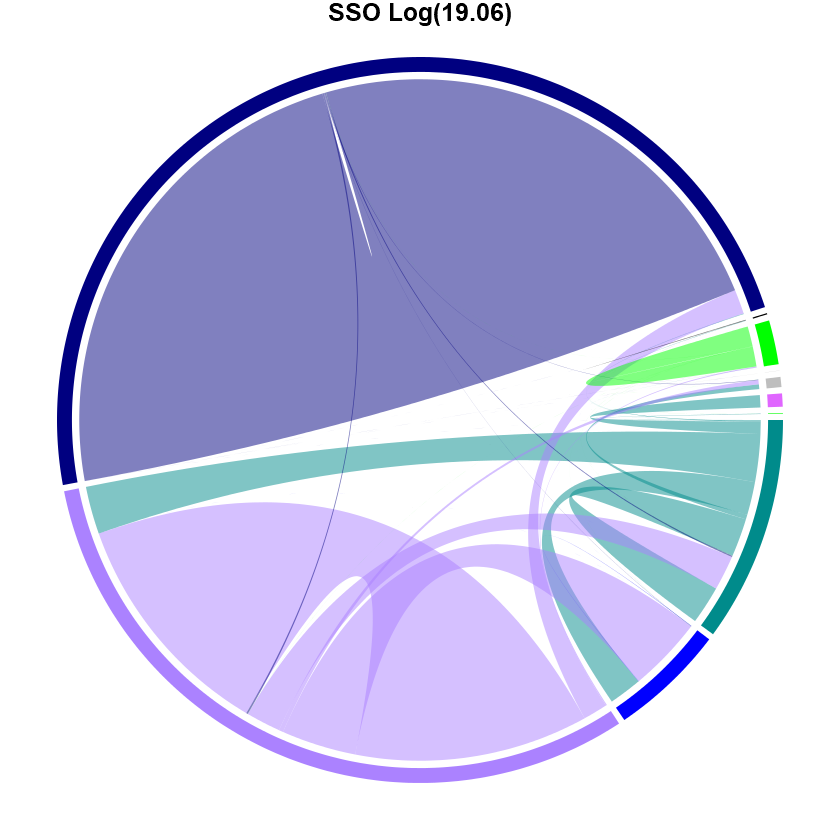

In [19]:
# options(repr.plot.width=5, repr.plot.height=5)
options(repr.plot.width=7, repr.plot.height=7)

chordDiagram(mat2, grid.col = grid.col, annotationTrack = "grid")
title("SSO Log(19.06)", cex = 0.8)

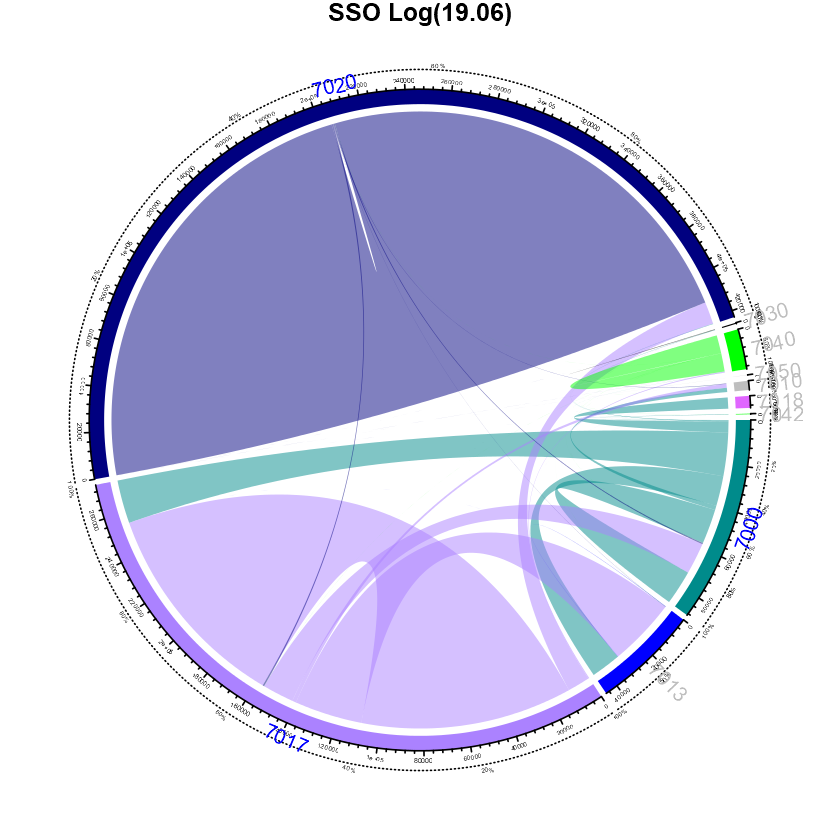

In [20]:
options(repr.plot.width=7, repr.plot.height=7)

chordDiagram(mat2, grid.col = grid.col, annotationTrack = "grid",
    preAllocateTracks = list(track.height = uh(5, "mm")))
title("SSO Log(19.06)", cex = 0.8)

for(si in get.all.sector.index()) {
    circos.axis(h = "top", labels.cex = 0.3, sector.index = si, track.index = 2)
}
circos.track(track.index = 1, panel.fun = function(x, y) {
    xlim = get.cell.meta.data("xlim")
    ylim = get.cell.meta.data("ylim")
    sector.name = get.cell.meta.data("sector.index")
    xplot = get.cell.meta.data("xplot")
    
    circos.lines(xlim, c(mean(ylim), mean(ylim)), lty = 3) # dotted line
    by = ifelse(abs(xplot[2] - xplot[1]) > 30, 0.2, 0.5)
    for(p in seq(by, 1, by = by)) {
        circos.text(p*(xlim[2] - xlim[1]) + xlim[1], mean(ylim) + 0.1, 
            paste0(p*100, "%"), cex = 0.3, adj = c(0.5, 0), niceFacing = TRUE)
    }
    
    # text표기(가로표기 혹은 세로표기)
    if(abs(xplot[2] - xplot[1]) < 20) {
        circos.text(mean(xlim), ylim[1], sector.name, facing = "clockwise",
            niceFacing = TRUE, adj = c(0, 0.5), col = "gray")
    } else {
        circos.text(mean(xlim), ylim[1], sector.name, facing = "inside", 
            niceFacing = TRUE, adj = c(0.5, 0), col= "blue")
    }
}, bg.border = NA)
circos.clear()

**현황**
+ 전체 트레픽 관점에서, 0to7 > maeili(Web) > Maeil Do > 다이렉트 > 상하농원 순으로 확인됨 
+ Maeil Do로 로그인한 경우, 관계사로 이동되는 경우가 많음
  + maeili Mobile page의 경우, 로그인시. maeili code가 삽입되지 않고 있음
+ 0to7 및 상하농원 이용자의 경우, 관계사로 이동되는 Case가 거의 없음
+ 한편, 매일 다이렉트의 경우에는 **maeili(Web)에서 유입**되는 경우가 **50%를 상회**함

**Graph(Comment)**
+ 장점
  + **다른 사이트로 이동**하는 경우, 절대적인 크기를 가늠할 수 있음(즉, 과대/과소 반영되지 않음)
  + 유입/유출의 경로가 명확하게 확인가능
+ 단점
  + **한 사이트에만** 머무는 경우, 출발지=도착지로 표시되면서 2배 가량 크게 보이는 경향이 있음
  + 표시 순서에 대한 임의 조정이 현재는 불가능

## Snakey Network

In [140]:
# edge <- read.csv('201905_SSO_log.csv')

In [21]:
edge_n <- as.data.frame(edge)

edge_n$IDsource=match(edge_n$source, node$code)-1 
edge_n$IDtarget=match(edge_n$target, node$code)-1

In [22]:
# str(edge_n)

In [23]:
# str(energy$links)

In [24]:
# nodes=data.frame(name=c(as.character(edge_n$source), as.character(edge_n$target)) %>% unique())

# edge_n$IDsource=match(edge_n$source, nodes$name)-1 
# edge_n$IDtarget=match(edge_n$target, nodes$name)-1

In [26]:
sankeyNetwork(Links = edge_n, Nodes = node, 
              Source = "IDsource", Target = "IDtarget", Value = "value",
              NodeID = 'name',   units = '껀',
              fontSize= 40, nodeWidth = 30, nodePadding= 60, sinksRight = T)

HTML widgets cannot be represented in plain text (need html)

In [70]:
# #sample
# # https://rdrr.io/cran/networkD3/man/sankeyNetwork.html

# URL <- paste0('https://cdn.rawgit.com/christophergandrud/networkD3/',
#               'master/JSONdata/energy.json')
# energy <- jsonlite::fromJSON(URL)


# # Plot
# sankeyNetwork(Links = energy$links, Nodes = energy$nodes, Source = 'source',
#              Target = 'target', Value = 'value', NodeID = 'name',
#              units = 'TWh', fontSize = 12, nodeWidth = 30)

In [101]:
# energy

In [44]:
# https://www.r-graph-gallery.com/321-introduction-to-interactive-sankey-diagram-2/